In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
from collections import Counter
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### Load Data


In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')

print("DATASET OVERVIEW")
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())

DATASET OVERVIEW

Dataset Shape: 37249 rows × 2 columns

First 5 rows:
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1


## 2 . Data Quality Check 

In [3]:
print("DATA QUALITY CHECK")

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
print(missing_summary)

print(f"\n--- Duplicate Rows ---")
print(f"Number of duplicates: {df.duplicated().sum()}")

DATA QUALITY CHECK

--- Data Types ---
clean_comment    object
category          int64
dtype: object

--- Missing Values ---
          Column  Missing Count  Missing Percentage
0  clean_comment            100                0.27
1       category              0                0.00

--- Duplicate Rows ---
Number of duplicates: 449


## 3. Data Cleaning

In [4]:
print("DATA CLEANING")

# Store original shape
original_shape = df.shape

# Step 1: Remove missing values
df.dropna(inplace=True)
print(f"✓ Removed NaN values: {original_shape[0] - df.shape[0]} rows dropped")

# Step 2: Remove duplicates
before_dup = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"✓ Removed duplicates: {before_dup - df.shape[0]} rows dropped")

# Step 3: Remove empty or whitespace-only comments
before_empty = df.shape[0]
df = df[~(df['clean_comment'].str.strip() == '')]
print(f"✓ Removed empty comments: {before_empty - df.shape[0]} rows dropped")

# Step 4: Text normalization
df['clean_comment'] = df['clean_comment'].str.lower()
df['clean_comment'] = df['clean_comment'].str.strip()
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)
print(f"✓ Applied text normalization (lowercase, strip whitespace, remove newlines)")

# Step 5: Remove non-English characters
df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))
print(f"✓ Removed non-English characters")

# Step 6: Lemmatization
lemmatizer = WordNetLemmatizer()
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)
print(f"✓ Applied lemmatization")

print(f"\nFinal Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Total rows removed: {original_shape[0] - df.shape[0]}")


DATA CLEANING
✓ Removed NaN values: 100 rows dropped
✓ Removed duplicates: 350 rows dropped
✓ Removed empty comments: 6 rows dropped
✓ Applied text normalization (lowercase, strip whitespace, remove newlines)
✓ Removed non-English characters
✓ Applied lemmatization

Final Dataset Shape: 36793 rows × 2 columns
Total rows removed: 456


## 4. Feature Engineering

In [5]:
print("FEATURE ENGINEERING")

# Word count
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))
print(f"✓ Created 'word_count' feature")

# Character count
df['num_chars'] = df['clean_comment'].apply(len)
print(f"✓ Created 'num_chars' feature")

# Stop words count
stop_words = set(stopwords.words('english'))
df['num_stop_words'] = df['clean_comment'].apply(
    lambda x: len([word for word in x.split() if word in stop_words])
)
print(f"✓ Created 'num_stop_words' feature")

# Punctuation count
df['num_punctuation_chars'] = df['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)
print(f"✓ Created 'num_punctuation_chars' feature")

print(f"\nSample of engineered features:")
print(df[['clean_comment', 'category', 'word_count', 'num_chars', 'num_stop_words']].head())


FEATURE ENGINEERING
✓ Created 'word_count' feature
✓ Created 'num_chars' feature
✓ Created 'num_stop_words' feature
✓ Created 'num_punctuation_chars' feature

Sample of engineered features:
                                       clean_comment  category  word_count  \
0  family mormon have never tried explain them th...         1          39   
1  buddhism ha very much lot compatible with chri...         1         196   
2  seriously don say thing first all they won get...        -1          86   
3  what you have learned yours and only yours wha...         0          29   
4  for your own benefit you may want read living ...         1         112   

   num_chars  num_stop_words  
0        256              13  
1       1257              57  
2        458              40  
3        167              15  
4        685              45  


## 5. EXPLORATORY DATA ANALYSIS

### 5.1 Sentiment Distribution

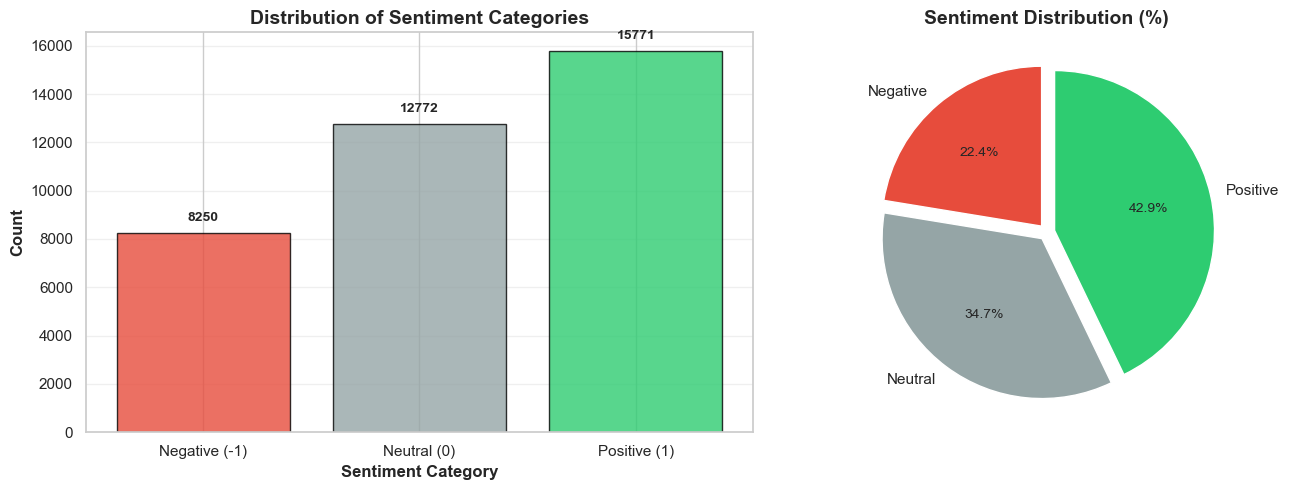


Sentiment Distribution:
  Negative:  22.42%
   Neutral:  34.71%
  Positive:  42.86%


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sentiment_counts = df['category'].value_counts().sort_index()
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Sentiment Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Sentiment Categories', fontsize=14, fontweight='bold')
axes[0].set_xticks([-1, 0, 1])
axes[0].set_xticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (idx, val) in enumerate(zip(sentiment_counts.index, sentiment_counts.values)):
    axes[0].text(idx, val + 500, str(val), ha='center', fontweight='bold')

# Pie chart
percentages = (df['category'].value_counts().sort_index() / len(df) * 100).round(2)
axes[1].pie(percentages.values, labels=['Negative', 'Neutral', 'Positive'], 
            autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.05, 0.05, 0.05))
axes[1].set_title('Sentiment Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSentiment Distribution:")
for cat, pct in zip([-1, 0, 1], percentages.values):
    cat_name = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}[cat]
    print(f"  {cat_name:>8}: {pct:>6.2f}%")

### 5.2 Word Count Statistics

count    36793.00
mean        29.53
std         56.48
min          0.00
25%          6.00
50%         13.00
75%         30.00
max       1307.00
Name: word_count, dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_43040\2886703849.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(box_data, labels=['Negative', 'Neutral', 'Positive'],


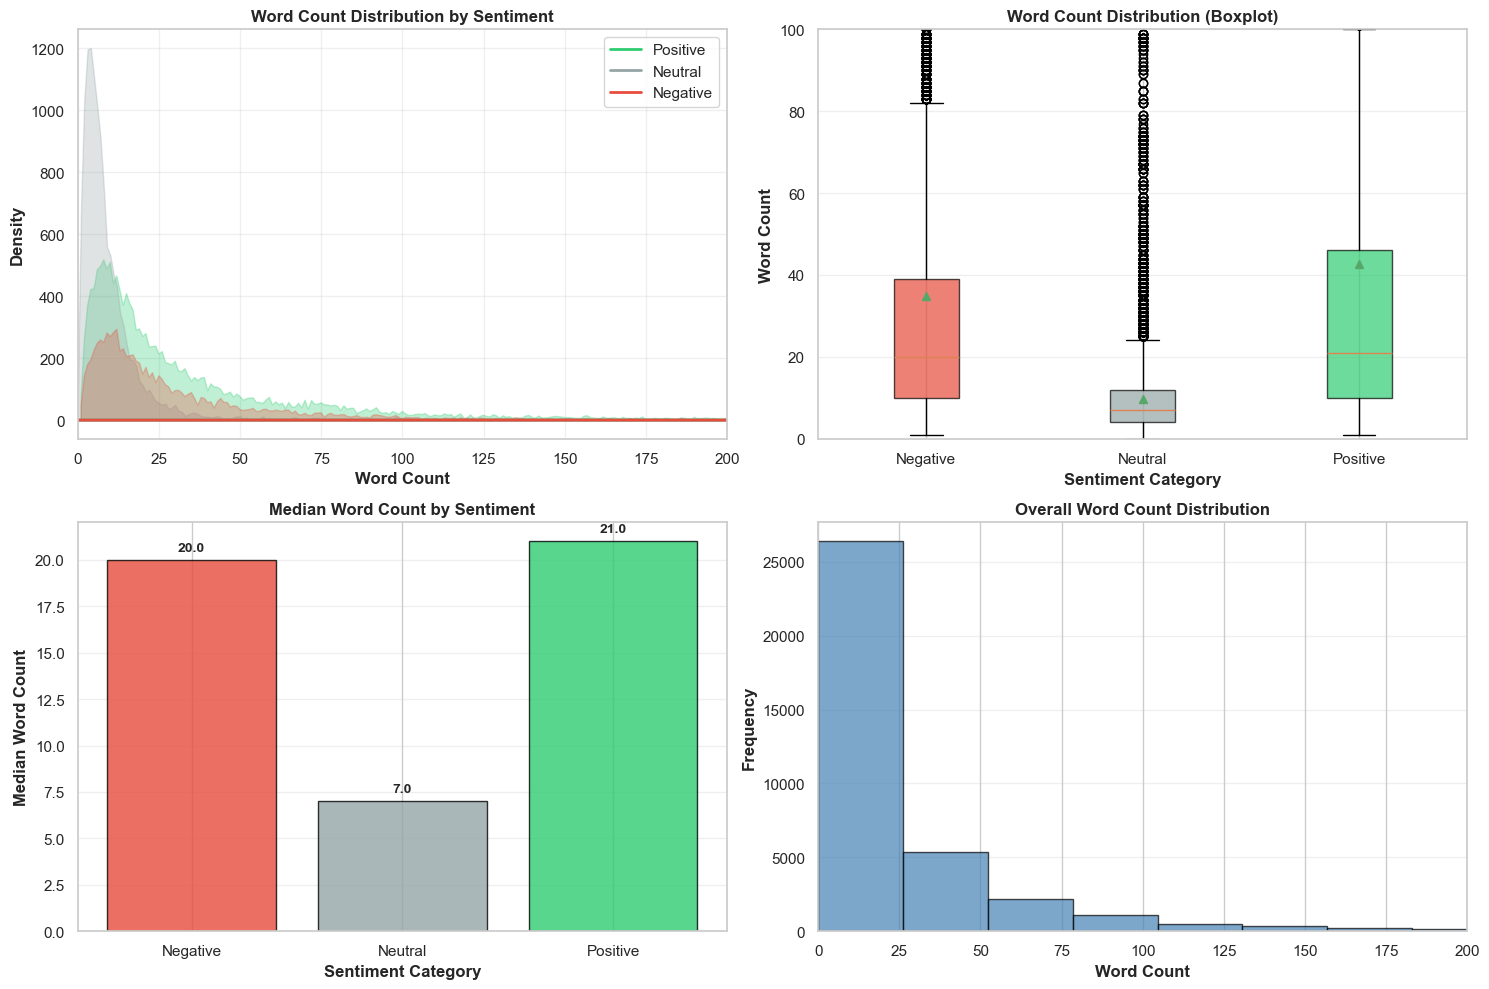

In [7]:
print(df['word_count'].describe().round(2))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# KDE Plot
for cat, color, label in zip([1, 0, -1], ['#2ecc71', '#95a5a6', '#e74c3c'], 
                              ['Positive', 'Neutral', 'Negative']):
    axes[0, 0].fill_between(
        df[df['category'] == cat]['word_count'].value_counts().sort_index().index,
        df[df['category'] == cat]['word_count'].value_counts().sort_index().values,
        alpha=0.3, color=color
    )
    df[df['category'] == cat]['word_count'].plot(kind='kde', ax=axes[0, 0], 
                                                   label=label, color=color, linewidth=2)
axes[0, 0].set_xlim(0, 200)
axes[0, 0].set_xlabel('Word Count', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box Plot
box_data = [df[df['category'] == cat]['word_count'] for cat in [-1, 0, 1]]
bp = axes[0, 1].boxplot(box_data, labels=['Negative', 'Neutral', 'Positive'], 
                         patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_ylim(0, 100)
axes[0, 1].set_xlabel('Sentiment Category', fontweight='bold')
axes[0, 1].set_ylabel('Word Count', fontweight='bold')
axes[0, 1].set_title('Word Count Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Median Bar Plot
median_data = df.groupby('category')['word_count'].median().sort_index()
axes[1, 0].bar([-1, 0, 1], median_data.values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Sentiment Category', fontweight='bold')
axes[1, 0].set_ylabel('Median Word Count', fontweight='bold')
axes[1, 0].set_title('Median Word Count by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks([-1, 0, 1])
axes[1, 0].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add median values on bars
for i, val in enumerate(median_data.values):
    axes[1, 0].text([-1, 0, 1][i], val + 0.5, f'{val:.1f}', ha='center', fontweight='bold')

# Histogram
axes[1, 1].hist(df['word_count'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlim(0, 200)
axes[1, 1].set_xlabel('Word Count', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Overall Word Count Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Stop Words Analysis

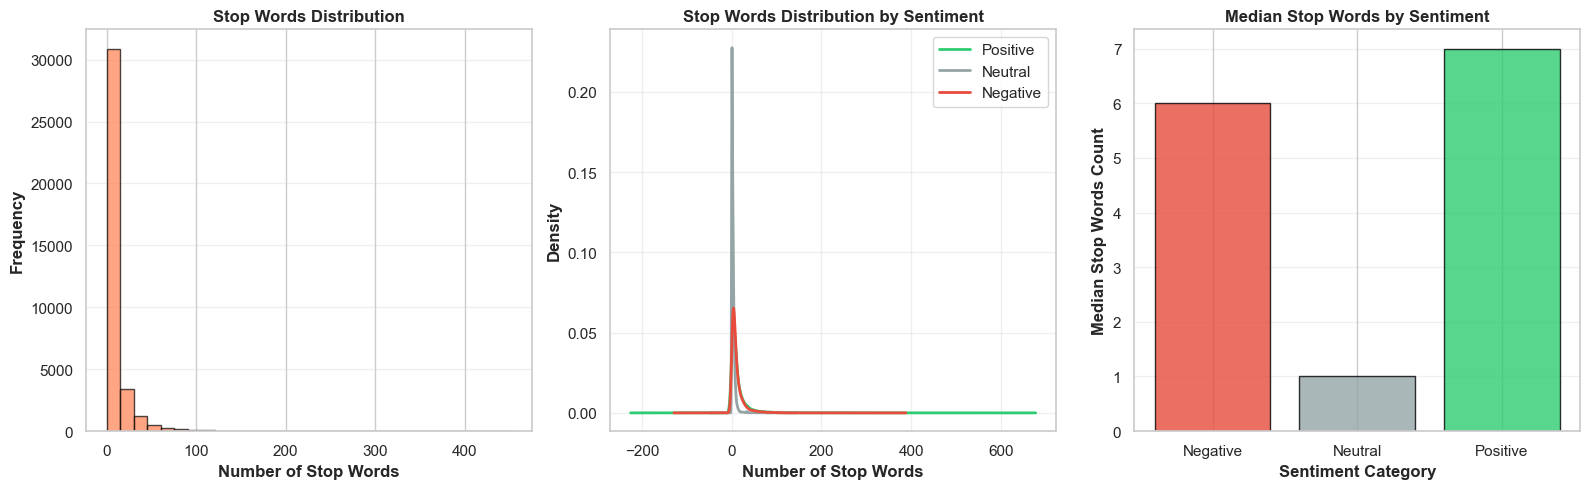

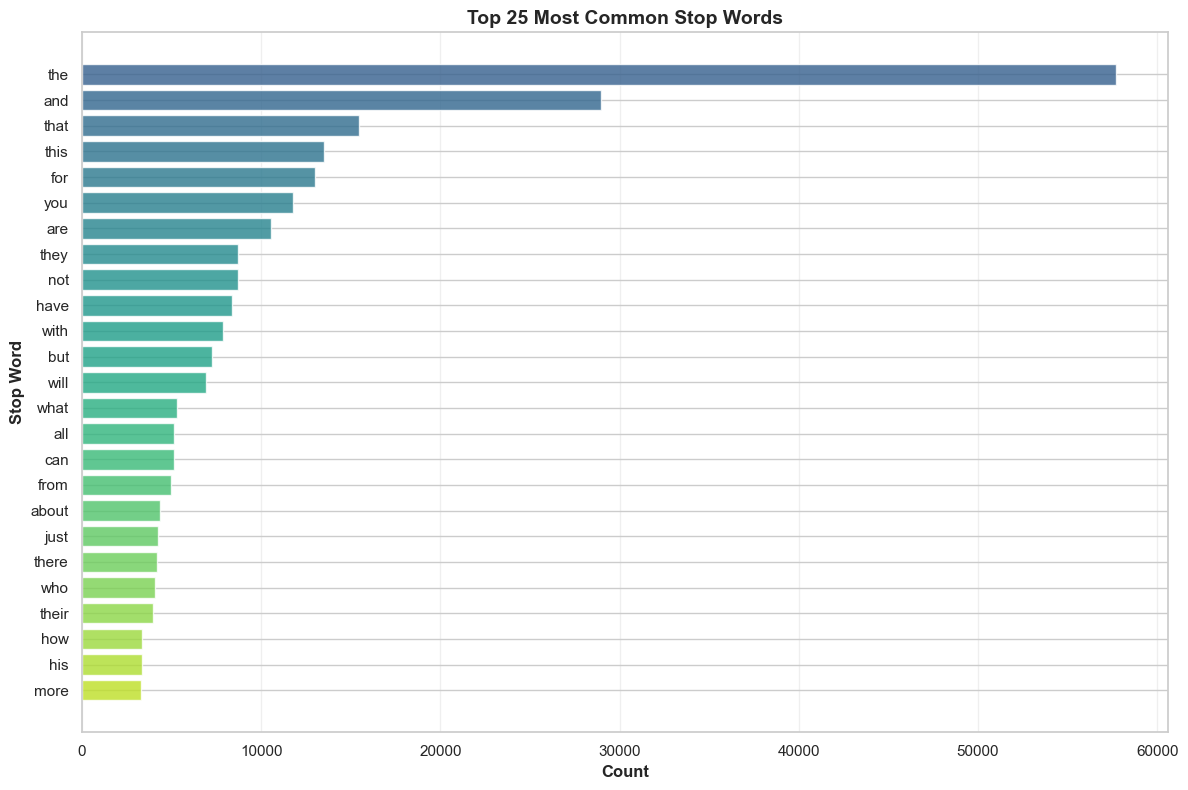

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribution histogram
axes[0].hist(df['num_stop_words'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Stop Words', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Stop Words Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# KDE by category
for cat, color, label in zip([1, 0, -1], ['#2ecc71', '#95a5a6', '#e74c3c'], 
                              ['Positive', 'Neutral', 'Negative']):
    df[df['category'] == cat]['num_stop_words'].plot(kind='kde', ax=axes[1], 
                                                       label=label, color=color, linewidth=2)
axes[1].set_xlabel('Number of Stop Words', fontweight='bold')
axes[1].set_ylabel('Density', fontweight='bold')
axes[1].set_title('Stop Words Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Median by category
median_stop_words = df.groupby('category')['num_stop_words'].median().sort_index()
axes[2].bar([-1, 0, 1], median_stop_words.values, color=colors, alpha=0.8, edgecolor='black')
axes[2].set_xlabel('Sentiment Category', fontweight='bold')
axes[2].set_ylabel('Median Stop Words Count', fontweight='bold')
axes[2].set_title('Median Stop Words by Sentiment', fontsize=12, fontweight='bold')
axes[2].set_xticks([-1, 0, 1])
axes[2].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Top 25 most common stop words
all_stop_words = [word for comment in df['clean_comment'] 
                  for word in comment.split() if word in stop_words]
most_common_stop_words = Counter(all_stop_words).most_common(25)
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

plt.figure(figsize=(12, 8))
colors_list = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_25_df)))
bars = plt.barh(range(len(top_25_df)), top_25_df['count'], color=colors_list, alpha=0.8)
plt.yticks(range(len(top_25_df)), top_25_df['stop_word'])
plt.xlabel('Count', fontsize=12, fontweight='bold')
plt.ylabel('Stop Word', fontsize=12, fontweight='bold')
plt.title('Top 25 Most Common Stop Words', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### 5.4 N-grams Analysis

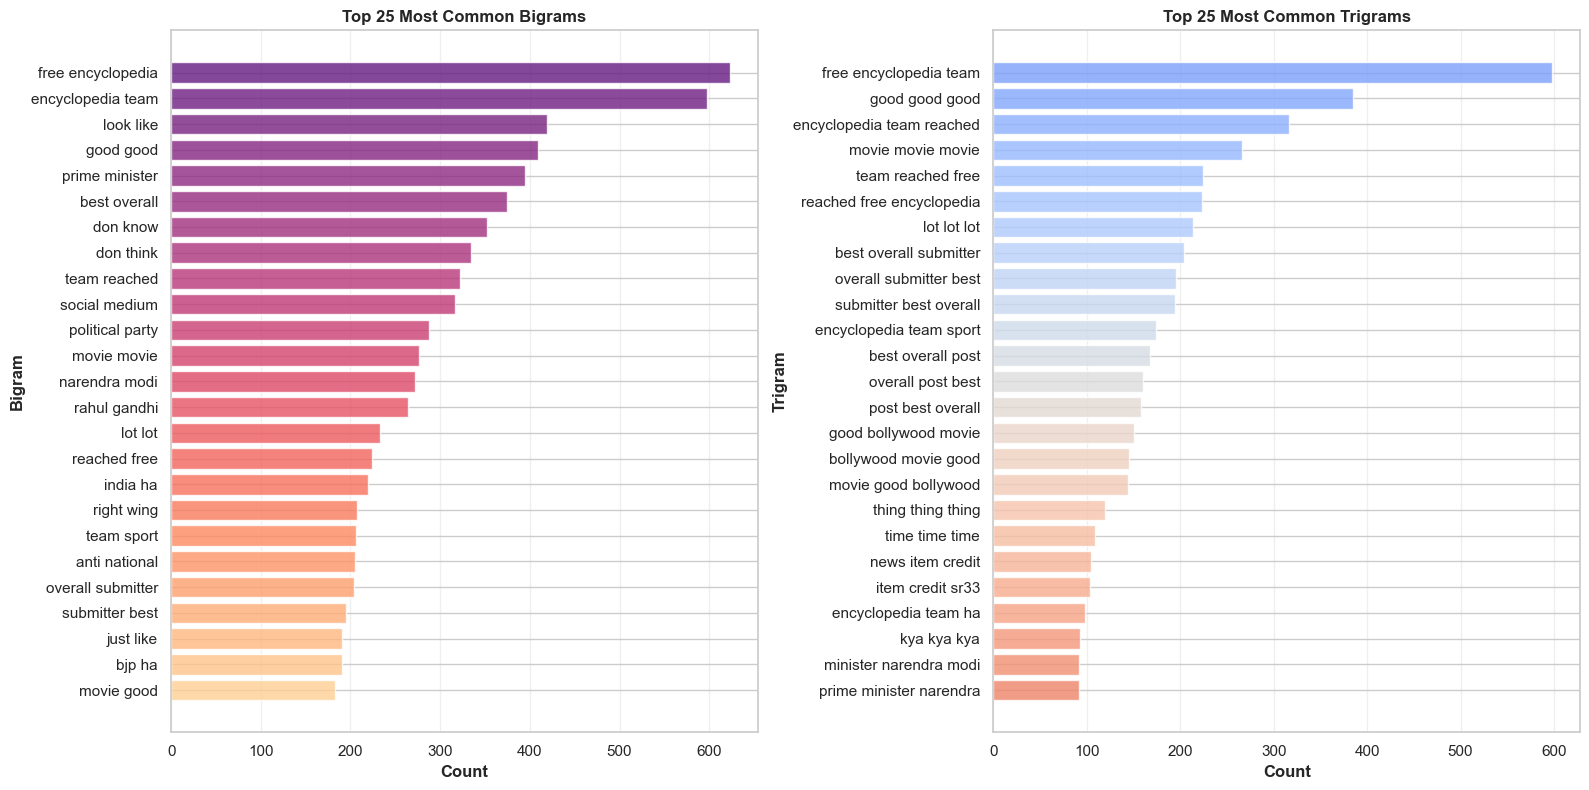

In [9]:
def get_top_ngrams(corpus, ngram_range, n=25):
    """Extract top N n-grams from corpus."""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bigrams
top_bigrams = get_top_ngrams(df['clean_comment'], (2, 2), 25)
bigrams_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])
bigram_colors = plt.cm.magma(np.linspace(0.3, 0.9, len(bigrams_df)))
axes[0].barh(range(len(bigrams_df)), bigrams_df['count'], color=bigram_colors, alpha=0.8)
axes[0].set_yticks(range(len(bigrams_df)))
axes[0].set_yticklabels(bigrams_df['bigram'])
axes[0].set_xlabel('Count', fontweight='bold')
axes[0].set_ylabel('Bigram', fontweight='bold')
axes[0].set_title('Top 25 Most Common Bigrams', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Trigrams
top_trigrams = get_top_ngrams(df['clean_comment'], (3, 3), 25)
trigrams_df = pd.DataFrame(top_trigrams, columns=['trigram', 'count'])
trigram_colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(trigrams_df)))
axes[1].barh(range(len(trigrams_df)), trigrams_df['count'], color=trigram_colors, alpha=0.8)
axes[1].set_yticks(range(len(trigrams_df)))
axes[1].set_yticklabels(trigrams_df['trigram'])
axes[1].set_xlabel('Count', fontweight='bold')
axes[1].set_ylabel('Trigram', fontweight='bold')
axes[1].set_title('Top 25 Most Common Trigrams', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### 5.5 Word Clouds

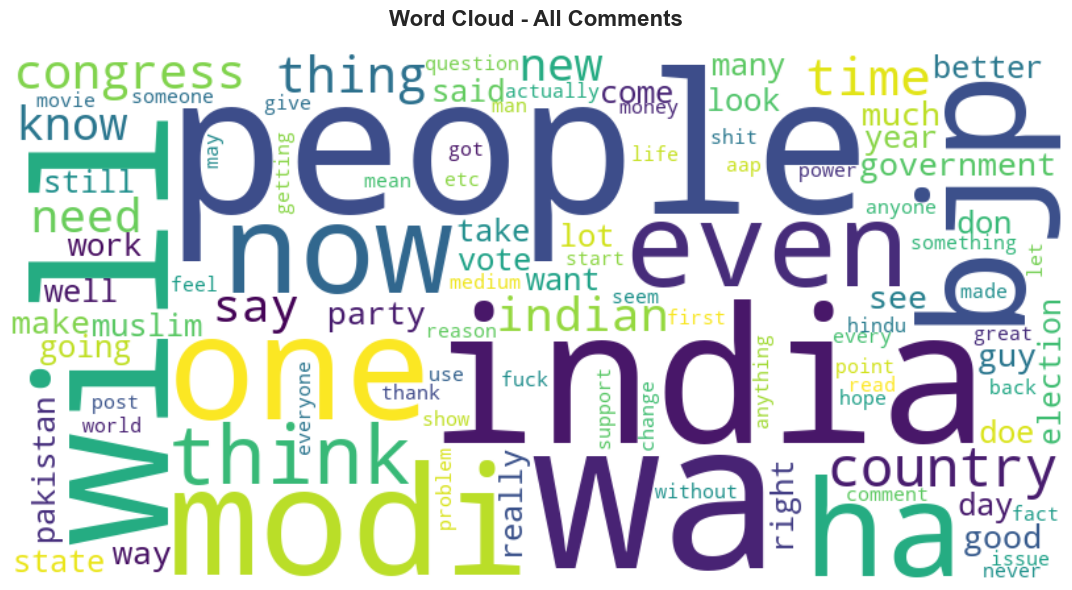

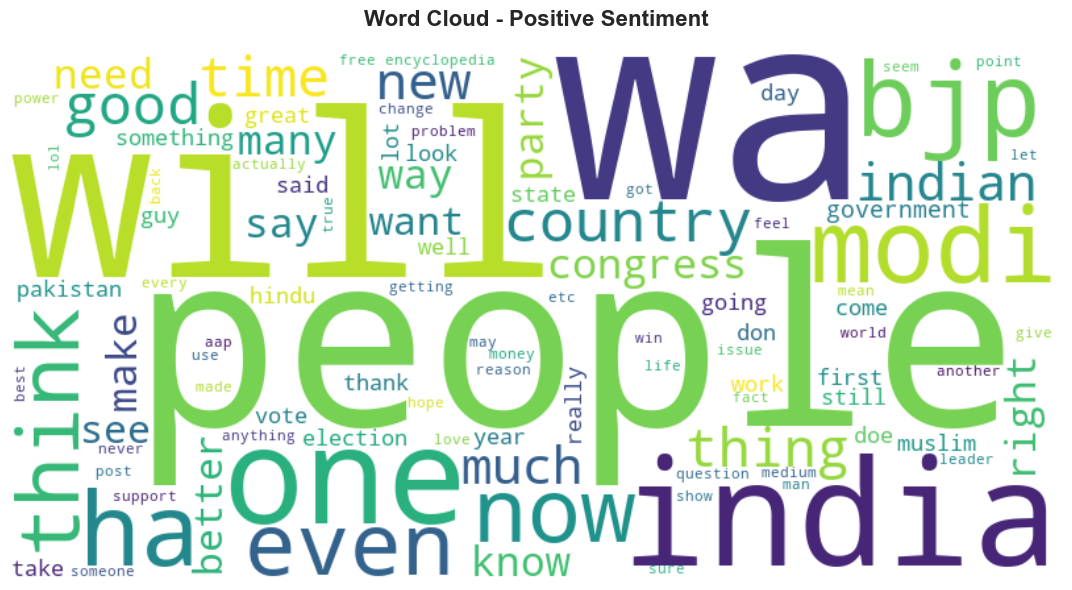

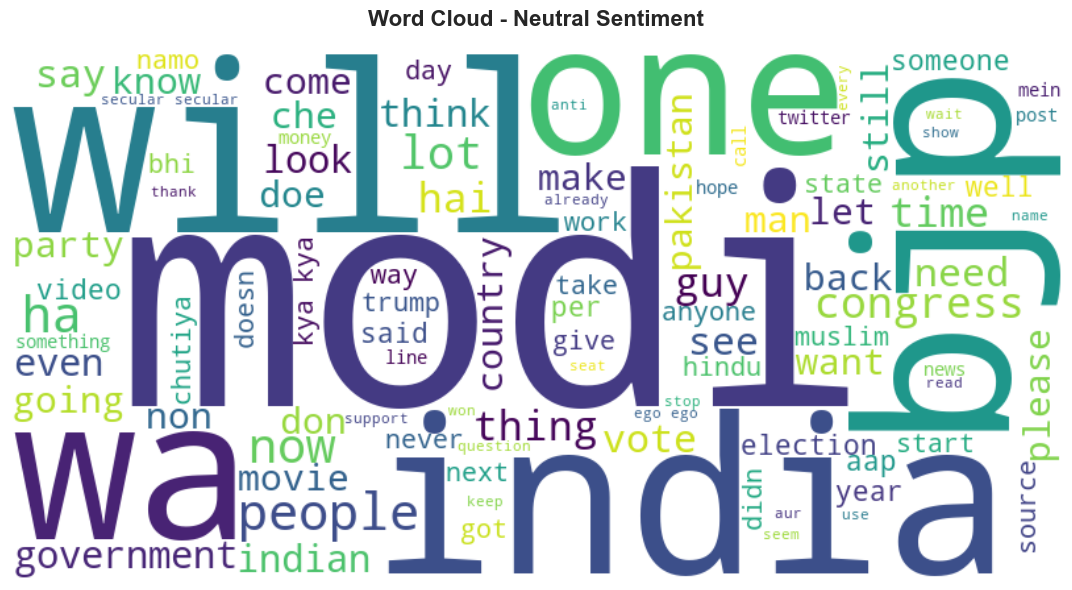

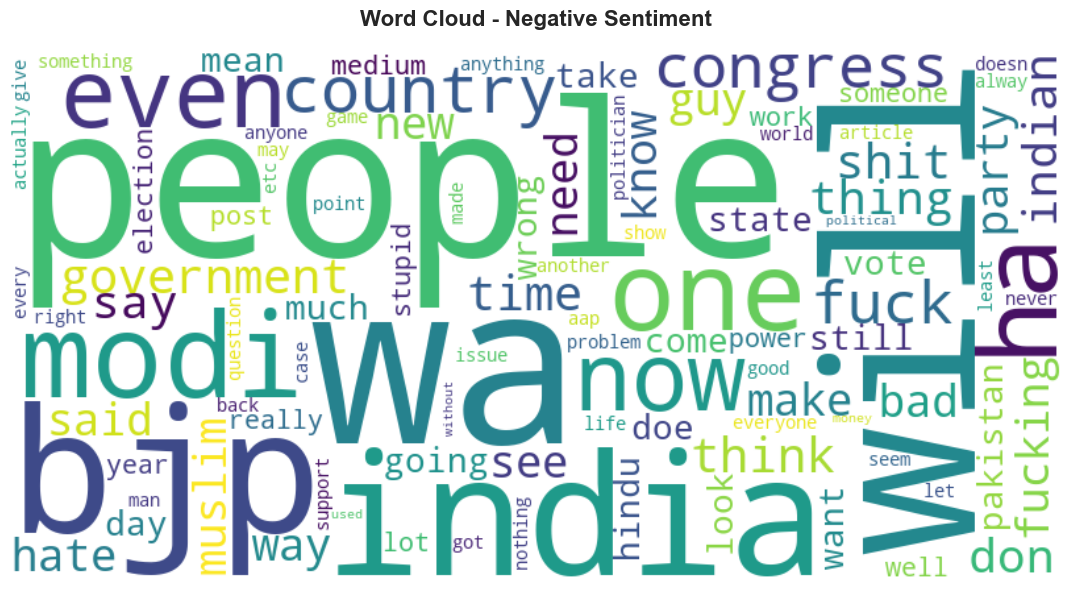

In [10]:
def create_wordcloud(text_series, title, color='white'):
    """Create and display a word cloud."""
    text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color=color,
                          colormap='viridis', max_words=100).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Overall word cloud
create_wordcloud(df['clean_comment'], 'Word Cloud - All Comments')

# Word clouds by sentiment
create_wordcloud(df[df['category'] == 1]['clean_comment'], 
                'Word Cloud - Positive Sentiment', 'white')
create_wordcloud(df[df['category'] == 0]['clean_comment'], 
                'Word Cloud - Neutral Sentiment', 'white')
create_wordcloud(df[df['category'] == -1]['clean_comment'], 
                'Word Cloud - Negative Sentiment', 'white')


### 5.6 Top Words Analysis

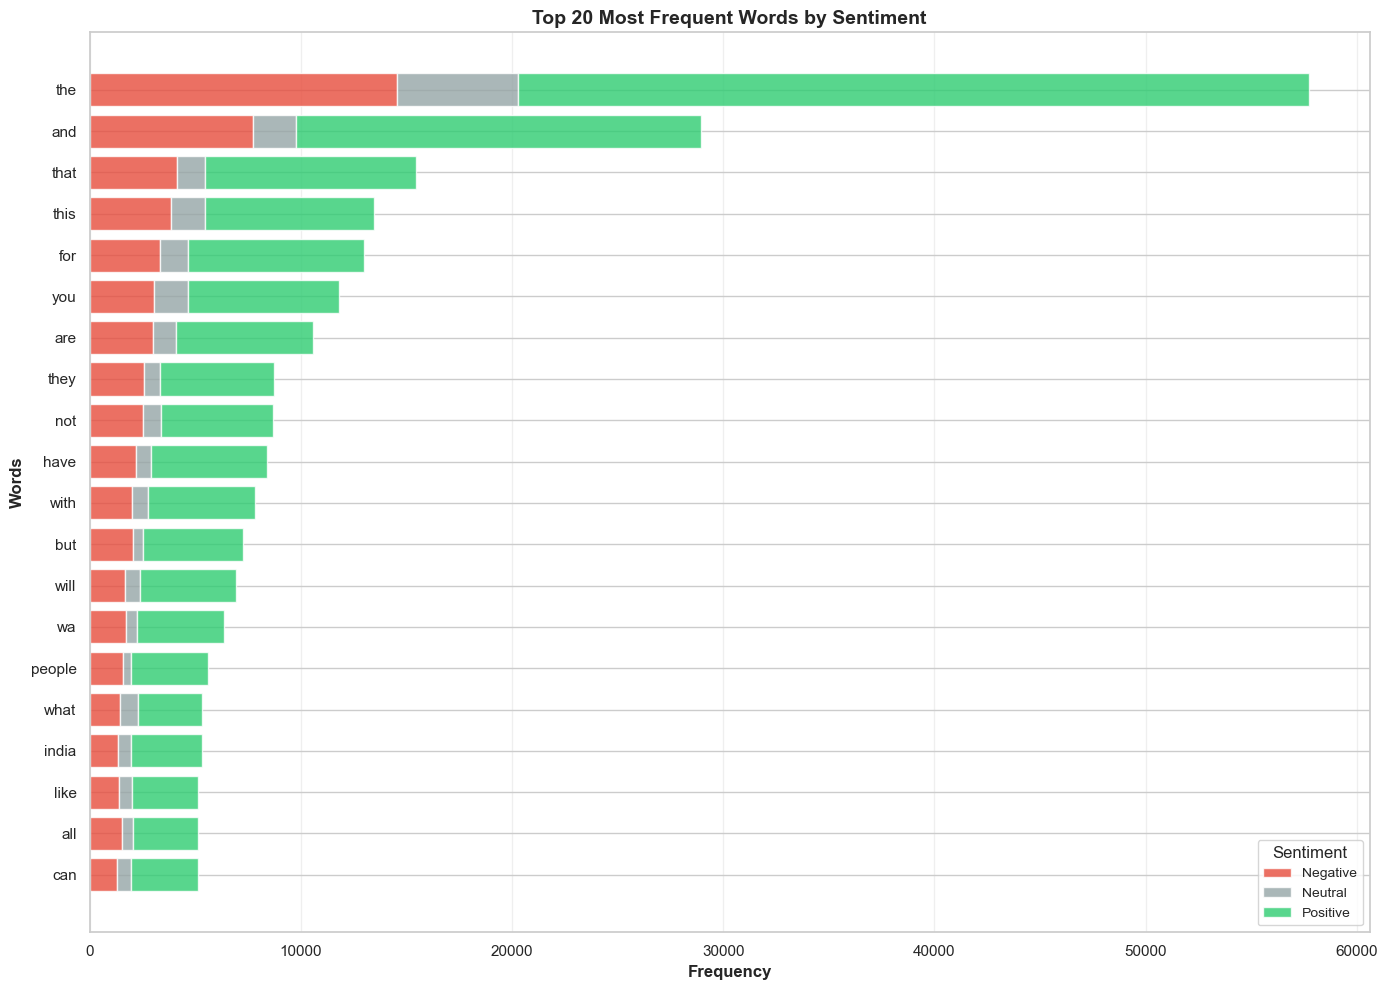

In [11]:
def plot_top_words_stacked(df, n=20):
    """Plot top N words with sentiment breakdown."""
    word_category_counts = {}
    
    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']
        
        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = {-1: 0, 0: 0, 1: 0}
            word_category_counts[word][category] += 1
    
    total_word_counts = {word: sum(counts.values()) 
                         for word, counts in word_category_counts.items()}
    most_common_words = sorted(total_word_counts.items(), 
                               key=lambda x: x[1], reverse=True)[:n]
    top_words = [word for word, _ in most_common_words]
    
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    bar_height = 0.8
    
    ax.barh(top_words, negative_counts, color='#e74c3c', 
            label='Negative', height=bar_height, alpha=0.8)
    ax.barh(top_words, neutral_counts, left=negative_counts, color='#95a5a6', 
            label='Neutral', height=bar_height, alpha=0.8)
    ax.barh(top_words, positive_counts, 
            left=[i+j for i, j in zip(negative_counts, neutral_counts)], 
            color='#2ecc71', label='Positive', height=bar_height, alpha=0.8)
    
    ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_ylabel('Words', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {n} Most Frequent Words by Sentiment', 
                fontsize=14, fontweight='bold')
    ax.legend(title='Sentiment', loc='lower right', fontsize=10)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_top_words_stacked(df, n=20)

## 6. Summary

In [12]:
print("SUMMARY STATISTICS")

summary_stats = df.groupby('category').agg({
    'word_count': ['mean', 'median', 'std'],
    'num_chars': ['mean', 'median', 'std'],
    'num_stop_words': ['mean', 'median', 'std']
}).round(2)

print("\nStatistics by Sentiment Category:")
print(summary_stats)

print("-----ANALYSIS COMPLETE------")


SUMMARY STATISTICS

Statistics by Sentiment Category:
         word_count               num_chars                num_stop_words  \
               mean median    std      mean median     std           mean   
category                                                                    
-1            34.79   20.0  52.11    210.80  116.0  328.50          11.36   
 0             9.75    7.0  12.37     58.06   38.0   77.44           2.69   
 1            42.78   21.0  73.42    259.69  125.0  459.22          14.11   

                        
         median    std  
category                
-1          6.0  16.76  
 0          1.0   5.05  
 1          7.0  24.34  
-----ANALYSIS COMPLETE------
